<a href="https://colab.research.google.com/github/franciscovillaescusa/ML_hydro/blob/master/Lecture1_Parameter_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CAMELS: Cosmology and Astrophysics with Machine Learning Simulations**
[https://www.camel-simulations.org]
- A collection of 4,233 N-body + state-of-the-art (magneto-)hydrodynamic simulations
- Simulations vary 6 cosmological + astrophysical parameters, $\{ \Omega_{\rm m}, \sigma_8, A_{\rm SN1}, A_{\rm SN2}, A_{\rm AGN1}, A_{\rm AGN2}\}$, plus initial random seed
- 2 suites: AREPO/IllustrisTNG + SIMBA/GIZMO
- Each suite contains 4 sets: 
  - **LH**. Each sim has a different values of cosmological, astrophysical and random seed. Organized in a latin-hypercube. 1,000 sims.
  - **1P**: From a central/fiducial cosmology, simulations vary the value of one single parameter at a time. Same random seed for all sims. 61 sims.
  - **CV**: All simulations have the same cosmology and astrophysics, only different random seed. To explore cosmic variance. 27 sims.
  - **EX**: A set of 3 extreme models: 1) No feedback, 2) extreme AGN feedback and 3) extreme supernova feedback. 3 sims.


We are going to use data from the LH set. In particular the Star-formation rate density (SFRH).

SFRH = Global rate of formation of stars per unit of volume. It is a function of redshift:

SFRH = SFRH(z)

When changing cosmology and astrophysics, this quantity will be affected. It is possible to infer the value of the cosmological and astrophysical parameters just from measurements of this quantity:

$\vec{\theta}=f({\rm SFRH}(z))$        
 where 
       
$\vec{\theta}=\{ \Omega_{\rm m}, \sigma_8, A_{\rm SN1}, A_{\rm SN2}, A_{\rm AGN1}, A_{\rm AGN2} \}$ 

We are going to approximate the function $f$ with a neural network.
#############################################################

Slides with the theory background can be found [here](https://docs.google.com/presentation/d/15kvXYfaQk245MgctHqlGipUJdcpMxXxsbU7d3vF_ga4/edit?usp=sharing).

#### Load libraries

In [6]:
import numpy as np
import sys,os,time
import torch 
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

#### If GPUs are available, use them

In [7]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


### Lets get familiar with the data

In [8]:
z      = np.linspace(0.0, 7.0, 100)            #redshifts of the SFRD
SFRD   = np.load('SFRH_IllustrisTNG.npy')      #read SFRD data
params = np.loadtxt('params_IllustrisTNG.txt') #read value of cosmological & astrophysics parameters

#### See the dimensions of the data


In [9]:
print(z.shape)
print(SFRD.shape)
print(params.shape)

(100,)
(1000, 100)
(1000, 6)


#### Lets plot the first two SFRD from the dataset

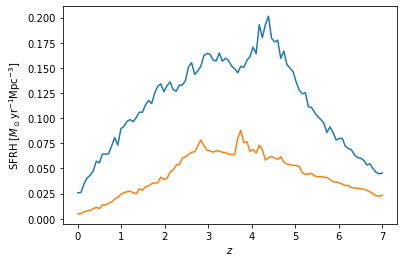

In [10]:
import matplotlib.pyplot as plt
 
plt.ylabel(r'${\rm SFRH}\,\,[M_\odot {\rm yr}^{-1}{\rm Mpc}^{-3}]$')
plt.xlabel(r'$z$')

plt.plot(z, SFRD[0])
plt.plot(z, SFRD[1])
 
plt.show()

#### Get the value of the cosmological and astrophysical parameters for these two SFRD

In [11]:
print('Sim: [Omega_m, sigma_8, A_SN1, A_AGN1, A_SN2, A_AGN2]')
print('0:  ',params[0])
print('1:  ',params[1])

Sim: [Omega_m, sigma_8, A_SN1, A_AGN1, A_SN2, A_AGN2]
0:   [0.309   0.979   3.11234 1.12194 0.6685  0.53182]
1:   [0.3026  0.9394  3.42001 3.96137 1.03311 1.1607 ]


### **Exercise**: calculate range of variation for each parameter, together with their mean value and standard deviation.

### Lets set the value of the (hyper-)parameters

In [73]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
f_SFRD         = 'SFRH_IllustrisTNG.npy'   #file with the SFRD data
f_params       = 'params_IllustrisTNG.txt' #file with the value of the parameters
min_valid_loss = 1e7                       #set this to a large number. Used to compute 

batch_size     = 32                        #number of elements each batch contains. Hyper-parameter
lr             = 3e-4                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
dr             = 0.2                       #dropout rate. Hyper-parameter
epochs         = 300                       #number of epochs to train the network. Hyper-parameter

f_model = 'best_model.pt'

### Lets write the function that loads the data.
For convenience, is good to use the pytorch data loader.
We need to define a python class and define the following two protocols:
- `__getitem__()`. Will return the input and output for one particular element of the dataset.
- `__len__()`. Will return the total number of elements in the dataset.italicized text.

It is important to normalize the data. There are two typical options:

- $\tilde{X}=(X-\bar{x})/\sigma_X$
- $\tilde{X}=[X-{\rm min}(X)]/[{\rm max}(X) - {\rm min}(X)]$

In [74]:
# This routine creates a dataset loader
# mode ---------> 'train', 'valid', 'test', 'all'. How to create the dataset
# f_SFRD -------> file containing the data for the SFRD
# f_params -----> file containing the value of the cosmological and astrophysical parameters
# batch_size ---> number of elements in the batch
# seed ---------> the data is randomly shuffled before being split into training, validation and testing. This set the random seed for that. 
def create_dataset(mode, f_SFRD, f_params, batch_size, seed):

    # create the class with the dataset
    data_set = make_dataset(mode, f_SFRD, f_params, seed)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)


# This class creates the dataset 
class make_dataset():

    def __init__(self, mode, f_SFRD, f_params, seed):

        # read the data
        SFRD   = np.load(f_SFRD)      #read SFRD data
        params = np.loadtxt(f_params) #read value of the parameters

        # normalize the value of the SFRD
        SFRD[np.where(SFRD==0.0)] = 1e-12 #avoid points with SFRD=0
        SFRD = np.log10(SFRD)
        mean = np.mean(SFRD, axis=0, dtype=np.float64)
        std  = np.std(SFRD,  axis=0, dtype=np.float64)
        SFRD = (SFRD - mean)/std

        # Normalize the value of the parameters
        min_params = np.min(params, axis=0)
        max_params = np.max(params, axis=0)
        params     = (params - min_params)/(max_params - min_params)

        # get the number of simulations and number of bins in the SFRD
        simulations = SFRD.shape[0]
        bins        = SFRD.shape[1]

        # get the size and offset depending on the type of dataset
        if   mode=='train':  
            size, offset = int(simulations*0.70), int(simulations*0.00)
        elif mode=='valid':  
            size, offset = int(simulations*0.15), int(simulations*0.70)
        elif mode=='test':   
            size, offset = int(simulations*0.15), int(simulations*0.85)
        elif mode=='all':
            size, offset = int(simulations*1.00), int(simulations*0.00)
        else:    raise Exception('Wrong name!')

        # define size, input and output arrays containing the data
        self.size   = size
        #self.input  = torch.zeros((size,bins), dtype=torch.float) #array with the SFRD
        #self.output = torch.zeros((size,6),    dtype=torch.float) #array with the parameters

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a 
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        indexes = np.arange(simulations)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size] #select indexes of the mode

        # get the corresponding parameters and SFRH
        self.input  = torch.tensor(SFRD[indexes],   dtype=torch.float32)
        self.output = torch.tensor(params[indexes], dtype=torch.float32)

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns 
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

# get the data
train_loader = create_dataset('train', f_SFRD, f_params, batch_size, seed) #training data
valid_loader = create_dataset('valid', f_SFRD, f_params, batch_size, seed) #validation data

### Lets define the architecture of the neural network
Use a python class and define the layers in the `__init__()` protocol and the model in the `forward()` routine.

In [75]:
class one_hidden_layer(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(one_hidden_layer, self).__init__()
        
        # define the fully connected layers
        self.fc1       = nn.Linear(input_size,  hidden_size) 
        self.fc2       = nn.Linear(hidden_size, output_size)

        # define the other layers
        self.dropout   = nn.Dropout(p=dropout_rate)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
       
    # forward pass
    def forward(self, x):
        out = self.fc1(x)
        out = self.LeakyReLU(out)
        out = self.dropout(out)
        out = self.fc2(out)         
        return out

# get the model and move it to the GPU
model = one_hidden_layer(100, 100, 6, dr) #architecture
model.to(device=device)                  #move the architecture to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

total number of parameters in the model = 10706


### Define the loss function and optimizer

In [76]:
criterion = nn.MSELoss()  #loss function. In this case MSE (mean squared error)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

## Train!

In [ ]:
start = time.time()

train_value = np.zeros(epochs)
valid_value = np.zeros(epochs)

# do a loop over all epochs
for epoch in range(epochs):
        
    # do training
    train_loss, points = 0.0, 0
    model.train()  #set this when training. Some architecture pieces, e.g. dropout behave differently
    for SFRH_train, params_train in train_loader:  #do a loop over all elements in the training set

        # get the size of the batch
        bs = SFRH_train.shape[0]

        # move data to GPU
        params_train = params_train.to(device) 
        SFRH_train   = SFRH_train.to(device)  

        # compute the value predicted by the network 
        params_pred  = model(SFRH_train)

        # compute loss 
        loss = criterion(params_pred, params_train)

        # compute cumulative loss and number of examples used
        train_loss += (loss.item())*bs
        points     += bs

        # zero gradients and do backpropagation. This is the magic!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # get the average training loss
    train_loss /= points
    train_value[epoch] = train_loss


    # do validation
    valid_loss, points = 0.0, 0
    model.eval()   #set this for validation and testing. Some architecture pieces, e.g. dropout behave differently
    for SFRH_val, params_val in valid_loader: # do a loop over all elements in the validation set
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the size of the batch
            bs = SFRH_val.shape[0]

            # move data to the GPU
            params_val = params_val.to(device)
            SFRH_val   = SFRH_val.to(device)

            # compute prediction by the network
            params_pred = model(SFRH_val)

            # compute cumulative loss and number of examples used
            valid_loss += (criterion(params_pred, params_val).item())*bs
            points     += bs

    # get the average validation loss
    valid_loss /= points
    valid_value[epoch] = valid_loss

    # save model if it has a lower validation loss
    print('%03d %.3e %.3e'%(epoch, train_loss, valid_loss), end='')
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        print(' (best-model)')
    else:
        print('')

    
stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

## Exercises:
- Save training and validation losses to file or array and make a plot with training loss and validation loss as a function of the number of epochs.
- Retrain the network using a larger number of epochs and redo the plot.
- Retrain the network using a higher and smaller value of the learning rate.
- Retrain the network using different values of the weight decay
- Retrain the network using a larger number of neurons per layer
- Change the architecture and implement a model with 3 hidden layers
- Play with all the possible things (learning rate, weight decay, number of hidden layers, number of neurons per layer, number of epochs...etc) and get the model with the lowest validation error

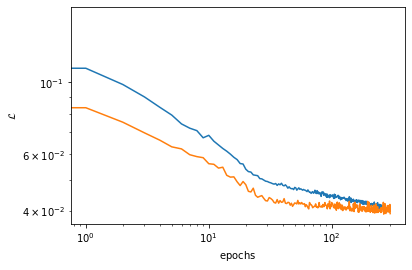

In [78]:
plt.ylabel(r'$\mathcal{L}$')
plt.xlabel(r'${\rm epochs}$')

plt.xscale('log')
plt.yscale('log')

epochs2 = np.arange(epochs)
plt.plot(epochs2, train_value)
plt.plot(epochs2, valid_value)
 
plt.show()

## Lets test the best-model!!

In [80]:
# get the test data
test_loader = create_dataset('test', f_SFRD, f_params, batch_size, seed) #test data

# load the best-model and move it to the GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

params_true = np.zeros((150,6), dtype=np.float32)
params_NN   = np.zeros((150,6), dtype=np.float32)

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()
count = 0
for SFRH_test, params_test in test_loader:
    with torch.no_grad():

        bs = SFRH_test.shape[0]

        # move data to GPU
        SFRH_test   = SFRH_test.to(device)
        params_test = params_test.to(device)
        
        # make prediction using network
        params_pred = model(SFRH_test)

        params_true[count:count+bs,:] = params_test.cpu().numpy()
        params_NN[count:count+bs, :]  = params_pred.cpu().numpy()

        # compute cumulative loss and number of examples used
        test_loss += (criterion(params_pred, params_test).item())*SFRH_test.shape[0]
        points += SFRH_test.shape[0]

        count += bs

# get the average validation loss
test_loss /= points

print('test loss = %.3e'%test_loss)

test loss = 4.577e-02


### **Exercise**: save in arrays or in a file the true and predicted values of the cosmological and astrophysical parameters. Take into account that the network will predict the normalized values, not the actual values. Make a plot with 6 panels. Each panel should have a scatter plot with the true value in the x-axis and the predicted value in the y-axis.

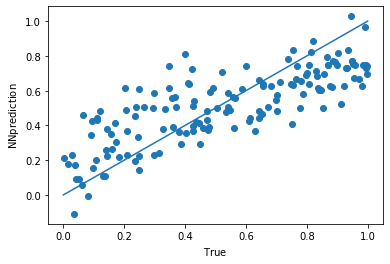

In [83]:
plt.ylabel(r'${\rm NN prediction}$')
plt.xlabel(r'${\rm True}$')

#plt.xscale('log')
#plt.yscale('log')

plt.scatter(params_true[:,0], params_NN[:,0])
plt.plot([0,1],[0,1])
#plt.plot(epochs2, valid_value)
 
plt.show()